<a href="https://colab.research.google.com/github/MLDS-UT-Austin/FantasyFootball/blob/main/NFL_Stats_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Fantasy Rules (ESPN)](https://www.espn.com/fantasy/football/ffl/story?page=fflrulesstandardscoring)

Webpage that explains the scoring rules for fantasy football. In general, we will draft offensive skill players (Quarterback, Runningback, Wide Receiver, and Tight End), a kicker, and a team's cumulative special teams and defense. Different counting stats help your score, while negative stats (such as giving the ball back to the other team through interceptions or fumbles) will remove points from your score.

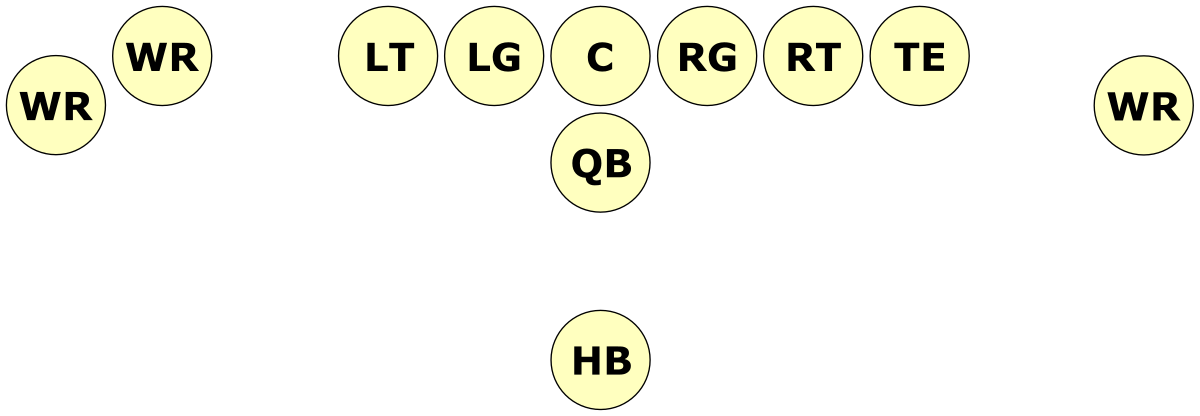

## [Pro Football Reference](https://www.pro-football-reference.com/)

Website that tracks a plethora of both counting and advanced stats for football. They have other sister sites for baseball and basketball as well.

## Cool NFL Data Stuff

Next Gen Stats also has some cool stats that aren't necessarily helpful here, but I find them to be fun for 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re

In [11]:
base_url = "https://www.pro-football-reference.com"
stat_categories = ["passing", "scrimmage", "kicking"]

if not os.path.exists("./yearly_stats/"):
    os.makedirs("./yearly_stats/")

if not os.path.exists("./player_gamelogs/"):
    os.makedirs("./player_gamelogs/")

# Going back as far as we'd like
years = [x for x in range(2010, 2022)]

In [12]:
def process_result(result):
    output = re.split(' |-', result['Result'])
    output[0] = output[0] == "W"
    return output

In [13]:
def add_urls(soup, urls, limit=50):
    links = soup.find_all('a')
    for link in links[:limit*2]:
        if not 'team' in link['href']:
            urls.add(link['href'])

In [14]:
# Initialize set for storing player URLs
player_urls = set()

for year in years:
    for stat in stat_categories:
        
        # Get webpage contents and begin parsing with bs4
        url = f"{base_url}/years/{year}/{stat}.htm"
        webpage = requests.get(url)
        page_soup = BeautifulSoup(webpage.content, 'html.parser')
        
        # Table's ID is slightly different when 
        if stat == "scrimmage":
            table_id = "receiving_and_rushing"
        else:
            table_id = stat
        
        table_soup = page_soup.find('table', {'id': table_id})
        
        if stat == "scrimmage":
            add_urls(table_soup, player_urls, 100)
        else:
            add_urls(table_soup, player_urls)
        
        stat_df = pd.read_html(str(table_soup))[0]
        
        # Clean dataset
        if stat != "passing":
            stat_df.columns = ['_'.join(col).strip('_') if "level" not in col[0] else col[1] for col in stat_df.columns.to_flat_index()]
            
        # Removes duplicate headers throughout table
        stat_df = stat_df[stat_df.Rk != "Rk"].set_index("Rk")
        
        # Converts emblemized award recognition to boolean column features
        stat_df['ProBowl'] = stat_df.Player.apply(lambda x: '*' in x)
        stat_df['AllPro'] = stat_df.Player.apply(lambda x: '+' in x)
        stat_df.Player = stat_df.Player.str.strip('*+')
        
        # Export dataset
        stat_df.to_csv(f"./yearly_stats/{year}_{stat}.csv", index=False)

In [15]:
# The full amount of player gamelogs we have!!!
len(player_urls)

762

In [21]:
# Laziest way I could import the set back in for comparison
completed_logs = set(pd.read_csv("./player_urls.csv").to_numpy().flatten())

In [22]:
# Since we're using sets, we can take the inverse of the union of our completed and newly grabbed sets
len(player_urls.difference(completed_logs))

0

In [25]:
# We now grab all of the career logs for those we don't already have.
new_logs = player_urls.difference(completed_logs)
if not new_logs:
    print("Completed all logs already")
else:
    for url in player_urls.difference(completed_logs):

        full_url = f"{base_url}{url[:-4]}/gamelog/"
        webpage = requests.get(full_url)
        page_soup = BeautifulSoup(webpage.content, 'html.parser')
        table_soup = page_soup.find('table', {'id': 'stats'})
        player_name = page_soup.find('h1', {'itemprop': 'name'}).text.strip()

        stat_df = pd.read_html(str(table_soup))[0]
        stat_df.columns = ['_'.join(col).strip('_') if "level" not in col[0] else col[1] for col in stat_df.columns.to_flat_index()]

        # Removes duplicate headers throughout table
        stat_df = stat_df[stat_df.Rk != "Rk"].set_index("Rk")

        # Convert Away to bool
        stat_df['Away_status'] = np.where(stat_df["Unnamed: 7_level_1"].isnull(), False, True)

        # Data Cleaning
        stat_df[['Win', 'Score', 'Opp Score']] = stat_df.apply(process_result, result_type='expand', axis=1)
        stat_df = stat_df.drop(["Unnamed: 7_level_1", "Result"], axis=1)
        stat_df['GS'] = np.where(stat_df['GS'].isnull(), False, True)
        stat_df['Player'] = player_name
        
        # Export to a new CSV and handle for duplicate player names
        export_path = f"./player_gamelogs/{player_name.replace(' ', '_')}.csv"
        counter = 1
        while os.path.exists(export_path):
            export_path = export_path[:-4] + str(counter) + export_path[-4:]
            counter += 1
        stat_df.to_csv(export_path, index=False)

Completed all logs already


In [24]:
pd.DataFrame(player_urls.union(completed_logs), columns=['URLs']).to_csv("./player_urls.csv", index=False)